# Basic Monte Carlo 

##### Keywords: sampling, rejection sampling, integration, lotus, law of large numbers, monte-carlo, expectations

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist

sns.set_style("white")
colors=sns.color_palette()

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', False)

## Monte Carlo

The basic idea of a Monte Carlo Algorithm is to use randomness to solve what is often a deterministic problem. In this course, we'll study their application in 3 different places: optimization, integration, and obtaining draws from a probability distribution. These uses are often intertwined: optimization is needed to find modes of distributions and integration to find expectations.

Wikipedia has a facinating bit of [history](https://en.wikipedia.org/wiki/Monte_Carlo_method) on the subject, from which I quote:

>The first thoughts and attempts I made to practice [the Monte Carlo Method] were suggested by a question which occurred to me in 1946 as I was convalescing from an illness and playing solitaires. The question was what are the chances that a Canfield solitaire laid out with 52 cards will come out successfully? After spending a lot of time trying to estimate them by pure combinatorial calculations, I wondered whether a more practical method than "abstract thinking" might not be to lay it out say one hundred times and simply observe and count the number of successful plays. This was already possible to envisage with the beginning of the new era of fast computers, and I immediately thought of problems of neutron diffusion and other questions of mathematical physics, and more generally how to change processes described by certain differential equations into an equivalent form interpretable as a succession of random operations. Later [in 1946], I described the idea to John von Neumann, and we began to plan actual calculations.
–Stanislaw Ulam

>Being secret, the work of von Neumann and Ulam required a code name.[citation needed] A colleague of von Neumann and Ulam, Nicholas Metropolis, suggested using the name Monte Carlo, which refers to the Monte Carlo Casino in Monaco where Ulam's uncle would borrow money from relatives to gamble.

## Estimate the area of a unit circle

To understand how randomness can be brought to bear upon solving deterministic problems, consider a very simple example: the value of $\pi$. If you could uniformly generate random numbers on a square, you could ask, how many of these numbers would fall inside a unit circle embedded in and touching the midpoints of the sides of the square. This ratio would be

$$\frac{\pi \times 1^2}{2^2} = \frac{\pi}{4}.$$

Area of the circle =  3.1608
pi =  3.141592653589793


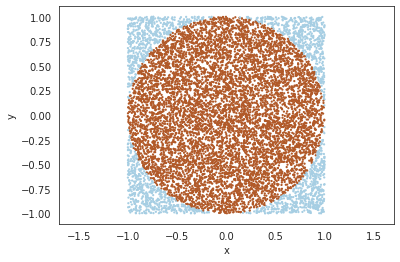

In [4]:
#area of the bounding box
box_area = 4.0    

#number of samples
N_total = 10000

#drawing random points uniform between -1 and 1
X = dist.Uniform(-1, 1).sample((N_total,)).numpy()
Y = dist.Uniform(-1, 1).sample((N_total,)).numpy()

# calculate the distance of the points from the center 
distance = np.sqrt(X**2+Y**2);  
 
# check if point is inside the circle    
is_point_inside = distance<1.0

# sum up the hits inside the circle
N_inside=np.sum(is_point_inside)

# estimate the circle area
circle_area = box_area * N_inside/N_total

# some nice visualization
plt.scatter(X,Y, c=is_point_inside, s=5.0, edgecolors='none', cmap=plt.cm.Paired)  
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')

# text output
print("Area of the circle = ", circle_area)
print("pi = ", np.pi)

Intuitively, one might expect our estimate of $\pi$ to get better as we draw more and more samples: we are covering the areas with samples much better when we do that.

Lets try to think about the mathematics in the intuition which tells us that we can calculate $\pi$ in this way. 

The area of the circle C can be obtained by computing a double integral like so:

$$A = \int_x \int_y I_{\in C}(x, y) dx dy = \int \int_{\in C} dx dy $$

where $I_{\in C} (x, y) = 1$ if
$x,y \in C$ and $I_{\in C}(x) = 0$ if $x,y \notin C$.

This is basically adding up all the small area elements inside the circle.

Remember from the LOTUS:

$$E_f[I_{\in C} (X,Y)] = \int I_{\in C} (X,Y) dF(X,Y) = \int_{\in C} dF(X,Y) = \int \int_{\in C} f_{X,Y} (x,y) dx dy = p(X,Y \in C)$$

and then we can use the law of large numbers to calculate this expectation and thus this probability.

The relationship of the expression all the way on the left to that all the way on the right is simply the law of large numbers we saw before. This is a distribution independent statement.

But the critical thing to notice is that:

$$\int \int_{\in C} f_{X,Y} (x,y) dx dy  =  \frac{1}{V} \int \int_{\in C}  dx dy = E_f[I_{\in C} (X,Y)]$$ 

once we choose a uniform distribution. Here $V$ is the support, the normalizing factor..here 4. The expectation from the law of large numbers comes from a sequence of identically distributed bernoullis (independent of $f$ which here is uniform). All we have to do, is just like before in the law, count the frequency of samples inside.




## Hit or miss method

This simple scenario of inside-or-outside can be used as a general (but poor, as missing increases exponentially with dimension)  way to use the generation of samples to carry out integration

![](images/hitormiss.png)

You basically generate samples from a uniform distribution with support on the rectangle and see how many fall below $y(x)$ at a specific x.

This is the basic idea behind rejection sampling